# Описание проекта

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Описание тарифов

Тариф «Смарт»
Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 3 рубля
сообщение: 3 рубля
1 Гб интернет-трафика: 200 рублей
Тариф «Ультра»
Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 1 рубль
сообщение: 1 рубль
1 Гб интернет-трафика: 150 рублей
Обратите внимание: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

### Открываем файлы и изучаем общую информацию 

In [1]:
#импортируем необходимые библиотеки

import pandas as pd

import numpy as np

from scipy import stats as st

import matplotlib.pyplot as plt

### Описание данных 1 таблицы users (информация о пользователях):

- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

In [2]:
#читаем файл
users = pd.read_csv('/datasets/users.csv', sep=',')

#общая информация
users.info()

#сумма дубликатов
users.duplicated().sum()

#выводим первые 5 строк
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Комментарии: таблица в предобработке данных не нуждается. 

In [3]:
#создаем таблицу из 2-х столбцов 'user_id','tariff'

users_short = users[['user_id','tariff']]

### Описание данных. Таблица calls (информация о звонках):

- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

In [4]:
#читаем файл
calls = pd.read_csv('/datasets/calls.csv', sep=',')

#общая информация
calls.info()

#выводим первые 5 строк
calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [5]:
#количество звонков с длительностью 0
print(len(calls.query('duration == 0')))

#удаляем строки и пересохраняем датафрейм
calls = calls.query('duration != 0')
calls.head()

39613


,id,call_date,duration,user_id
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000


Обратите внимание: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

In [6]:
#округление до целого в большую сторону
calls['duration'] = np.ceil(calls['duration']).astype('int')

In [7]:
#переводим в формат даты
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%dT%H:%M:%S')

#создаем столбец с месяцем
calls['call_month'] = pd.DatetimeIndex(calls['call_date']).month

Посчитайте для каждого пользователя:
количество сделанных звонков и израсходованных минут разговора по месяцам;

In [8]:
#группируем по пользователям и месяцам и считаем количество звонков и сумму минут
#пропуски заменяем на 0
#переименовываем столбцы
calls_grouped = (calls.
                 pivot_table(index = ['user_id','call_month'], values = 'duration', aggfunc =['count', 'sum'])
                 .fillna(value='0')
                 .reset_index())
calls_grouped.columns = ['user_id', 'month','calls_number', 'calls_sum']

calls_grouped

,user_id,month,calls_number,calls_sum
0,1000,5,17,159
1,1000,6,28,172
2,1000,7,41,340
3,1000,8,42,408
4,1000,9,46,466
...,...,...,...,...
3163,1498,10,30,247
3164,1499,9,8,70
3165,1499,10,44,449
3166,1499,11,62,612


### Описание данных. Таблица messages (информация о сообщениях):

- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

In [9]:
#читаем файл
messages = pd.read_csv('/datasets/messages.csv', sep=',')

#общая информация
messages.info()

#выводим первые 5 строк
messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Посчитайте для каждого пользователя: количество отправленных сообщений по месяцам

In [10]:
#перевели в формат даты
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%dT%H:%M:%S')

#определили месяц
messages['message_month'] = pd.DatetimeIndex(messages['message_date']).month

messages.head()

,id,message_date,user_id,message_month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


In [11]:
#создали сводную таблицу, сгруппированную по user_id,message_month, в ячейках - количество сообщений
#NaN заполнили 0 
messages_grouped = (messages
                    .pivot_table(index=['user_id','message_month'], values='message_date', aggfunc='count')
                    .reset_index()
                    .fillna(value='0'))

#переименовали столбцы
messages_grouped.columns = ['user_id', 'month', 'number_messages']         

messages_grouped

,user_id,month,number_messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


### Описание данных. Таблица internet (информация об интернет-сессиях):

- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

In [12]:
#читаем файл
internet = pd.read_csv('/datasets/internet.csv', sep=',')

#общая информация
internet.info()

#выводим первые 5 строк
internet.head()

#округление до целого в большую сторону
internet['mb_used'] = np.ceil(internet['mb_used']).astype('int')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Посчитать: объем израсходованного интернет-трафика по месяцам

In [13]:
#перевели в формат даты
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%dT%H:%M:%S')
internet['session_month'] = pd.DatetimeIndex(internet['session_date']).month

#создали сводную таблицу, сгруппированную по user_id, session_month, в ячейках - расход трафика
internet_grouped = (internet
                    .pivot_table(index=['user_id','session_month'], values='mb_used', aggfunc='sum')
                    .reset_index()
                    .fillna(value='0'))

#переименовали столбцы
internet_grouped.columns = ['user_id', 'month', 'mb_used']
internet_grouped

,user_id,month,mb_used
0,1000,5,2256
1,1000,6,23257
2,1000,7,14016
3,1000,8,14070
4,1000,9,14581
...,...,...,...
3198,1498,10,20604
3199,1499,9,1848
3200,1499,10,17809
3201,1499,11,17984


In [14]:
#объединили основные таблицы  
result = (calls_grouped
          .merge(messages_grouped, on=['user_id', 'month'], how='left')
          .merge(internet_grouped, on=['user_id', 'month'], how='left')
          .merge(users_short,on='user_id', how='left'))
result.head()

,user_id,month,calls_number,calls_sum,number_messages,mb_used,tariff
0,1000,5,17,159,22.0,2256.0,ultra
1,1000,6,28,172,60.0,23257.0,ultra
2,1000,7,41,340,75.0,14016.0,ultra
3,1000,8,42,408,81.0,14070.0,ultra
4,1000,9,46,466,57.0,14581.0,ultra


### Описание данных. Таблица tariffs (информация о тарифах):

- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [15]:
#читаем файл
tariffs = pd.read_csv('/datasets/tariffs.csv', sep=',')

tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


### Расчет профита

Посчитать: помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану)

In [16]:
#функция для расчета количество звонков больше лимита в зависимости от тарифа
#добавление нового столбца 

def extra_calls_sum(row):
    calls_sum = row['calls_sum']
    if (row['tariff'] == 'smart') & (row['calls_sum'] > 500):       #если тариф smart и звонков более 500 мин в месяц
        extra_calls = calls_sum - 500                               #посчить сумму звонков выше лимита
        return extra_calls
    elif (row['tariff'] == 'ultra') & (row['calls_sum'] > 3000):    #если тариф ultra и звонков более 3000 в месяц
        extra_calls = calls_sum - 3000                              #посчить сумму звонков выше лимита
        return extra_calls
    else: 
        return 0                                                    #если лимит не превышен, оставить 0

result['extra_calls'] = result.apply(extra_calls_sum, axis=1)       #добавить новый столбец и применить функцию 
        

In [17]:
#функция для расчета сообщений больше лимита в зависимости от тарифа
#добавление нового столбца

def extra_messages_sum(row):
    number_messages = row['number_messages']
    if (row['tariff'] == 'smart') & (row['number_messages'] > 50):       #если тариф smart и сообщений более 50 в месяц
        extra_messages = number_messages - 50                            #посчить сообщения выше лимита
        return extra_messages
    elif (row['tariff'] == 'ultra') & (row['number_messages'] > 1000):   #если тариф ultra и сообщений более 1000 в месяц
        extra_calls = number_messages - 1000                             #посчить сообщения выше лимита
        return extra_messages
    else: 
        return 0                                                         #если лимит сообщений не превышен, оставить 0

result['extra_messages'] = result.apply(extra_messages_sum, axis=1)      #добавить новый столбец и применить функцию 

In [18]:
#функция для расчета трафика больше лимита в зависимости от тарифа
#добавление нового столбца

def extra_mb_sum(row):
    mb_used = row['mb_used']
    if (row['tariff'] == 'smart') & (row['mb_used'] > 15360):
        extra_mb = mb_used - 15360
        return extra_mb
    elif (row['tariff'] == 'ultra') & (row['mb_used'] > 30720):
        extra_mb = mb_used - 30720
        return extra_mb
    else: 
        return 0

result['extra_mb'] = result.apply(extra_mb_sum, axis=1)

#перевели значение из мб в гб
#округлили в большую сторону
result['extra_mb'] = result['extra_mb'] / 1024
result['extra_mb'] = np.ceil(result['extra_mb']).astype('int')


In [19]:
#функция для расчета выручки 

def profit(row):
    extra_calls = row['extra_calls']                        #берем значения из столбца звонки выше лимита
    extra_messages = row['extra_messages']                  #берем значения из столбца сообщения выше лимита
    extra_mb = row['extra_mb']                              #берем значения из столбца трафик выше лимита

    #рассчитываем выручку по каждому тарифу
    if row['tariff'] == 'smart':
        profit = extra_calls * 3 + extra_messages * 3 + extra_mb *200 + 550    
        return profit
    if row['tariff'] == 'ultra':
        profit = extra_calls * 1 + extra_messages * 1 + extra_mb *150 + 1950
        return profit

result['profit'] = result.apply(profit, axis=1)             #добавляем новый столбец и применяем функцию


In [20]:
#итоговая таблица с выручкой
result.head()

,user_id,month,calls_number,calls_sum,number_messages,mb_used,tariff,extra_calls,extra_messages,extra_mb,profit
0,1000,5,17,159,22.0,2256.0,ultra,0,0.0,0,1950.0
1,1000,6,28,172,60.0,23257.0,ultra,0,0.0,0,1950.0
2,1000,7,41,340,75.0,14016.0,ultra,0,0.0,0,1950.0
3,1000,8,42,408,81.0,14070.0,ultra,0,0.0,0,1950.0
4,1000,9,46,466,57.0,14581.0,ultra,0,0.0,0,1950.0


### Анализ данных

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

In [21]:
#делаем срез и создаем таблицу по тарифу smart
result_smart = result.query('tariff=="smart"')

#делаем срез и создаем таблицу по тарифу ultra
result_ultra = result.query('tariff=="ultra"')

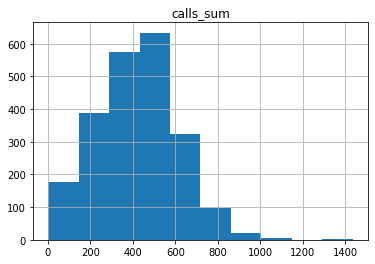

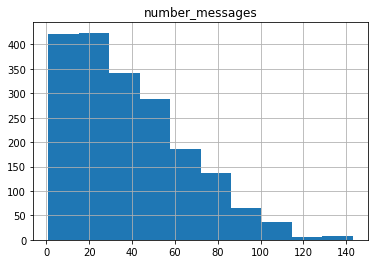

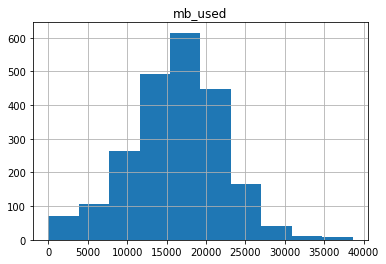

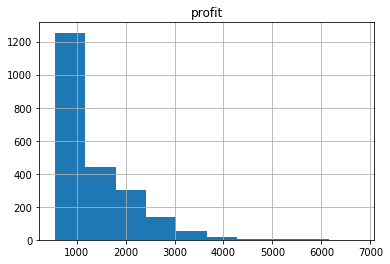

In [22]:
#создали функцию для составления гистограмм для пользователей "smart"
for column in ['calls_sum','number_messages', 'mb_used', 'profit']:
    result_smart.hist(column, bins=10)
    plt.show()

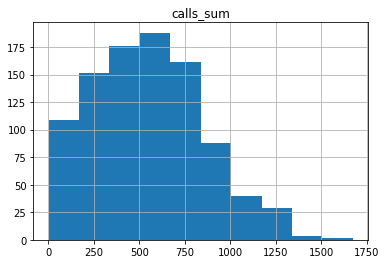

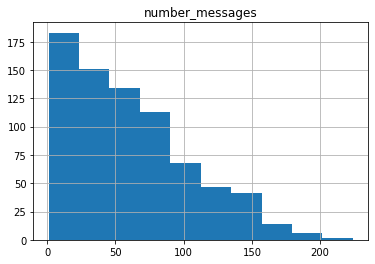

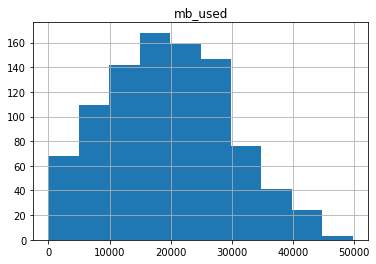

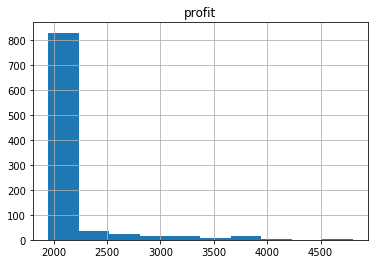

In [23]:
#создали функцию для составления гистограмм для пользователей "smart"
for column in ['calls_sum','number_messages', 'mb_used', 'profit']:
    result_ultra.hist(column, bins=10)
    plt.show()

In [24]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [25]:
#характерные значения для тарифа smart
result_smart[['calls_sum', 'number_messages', 'mb_used', 'profit']].describe()

,calls_sum,number_messages,mb_used,profit
count,2221.000000,1914.000000,2220.000000,2221.000000
mean,419.440342,38.748171,16238.773874,1295.790635
std,188.992403,26.829451,5874.671624,821.847974
min,2.000000,1.000000,0.000000,550.000000
25%,285.000000,17.000000,12679.500000,550.000000
50%,423.000000,34.000000,16529.000000,1039.000000
75%,546.000000,55.000000,20071.000000,1750.000000
max,1435.000000,143.000000,38610.000000,6770.000000


In [26]:
#дисперии 
np.var(result_smart,ddof=1)

user_id            2.127327e+04
month              8.513005e+00
calls_number       4.362706e+02
calls_sum          3.571813e+04
number_messages    7.198195e+02
mb_used            3.451177e+07
extra_calls        7.190040e+03
extra_messages     1.812291e+02
extra_mb           1.370157e+01
profit             6.754341e+05
dtype: float64

In [27]:
result_ultra[['calls_sum', 'number_messages', 'mb_used', 'profit']].describe()

,calls_sum,number_messages,mb_used,profit
count,947.000000,759.000000,937.000000,947.000000
mean,547.755016,60.836627,19697.673426,2072.439282
std,305.513385,44.436961,9987.784846,382.831425
min,1.000000,1.000000,0.000000,1950.000000
25%,311.000000,25.000000,11884.000000,1950.000000
50%,529.000000,52.000000,19444.000000,1950.000000
75%,758.000000,87.000000,26952.000000,1950.000000
max,1673.000000,224.000000,49789.000000,4800.000000


In [28]:
#дисперии 
np.var(result_ultra,ddof=1)

user_id            1.979845e+04
month              8.308815e+00
calls_number       1.168901e+03
calls_sum          9.333843e+04
number_messages    1.974643e+03
mb_used            9.975585e+07
extra_calls        0.000000e+00
extra_messages     0.000000e+00
extra_mb           6.513773e+00
profit             1.465599e+05
dtype: float64

Пользователи тарифа "Smart" тратят в среднем в месяц:
- 419 минут на разговоры,
- 16238 мб интернета,
- отправляют 38 сообщений
- Приносят профит 1295 рублей за счет использования дополнительного трафика интернета, так как на звонки и сообщения попадают под лимит, но дисперсия и отклонение выше, чем для тарифа ультра. То есть можно предположить, что абоненты, которые тратят трафик больше готовы будут перейти на другой тариф

Пользователи тарифа "Ultra" тратят в среднем в месяц:
- 547 минут на разговоры,
- 19697 мб интернета,
- отправляют 60 сообщений
- Приносят профит 2072 рубля, причем отклонение от этой цифры небольшое

## Проверка гипотез 

Нулевая гипотеза: средние по выручке 2-х тарифов  равны.  Альтернативная гипотеза: средние - не равны.

In [29]:
result_smart_profit = result_smart['profit']
result_ultra_profit = result_ultra['profit']

alpha = 0.05   #уровень статистической значимости 5%

proverka = st.ttest_ind(
    result_smart_profit,
    result_ultra_profit)

print('p-значение', proverka.pvalue)

if (proverka.pvalue < alpha):
    print('Отвергаем нулевую гипотезу. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается')
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение 1.399451579946976e-152
Отвергаем нулевую гипотезу. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается


In [30]:
#объединили итоговую таблицу с таблицей users
result_region = result.merge(users, on='user_id')

In [31]:
#новая таблица с итоговыми результатами, город Москва
result_Moscow = result_region.query('city=="Москва"')

#новая таблицу с итоговыми результатами, другие регионы
result_other = result_region.query('city!="Москва"')

result_Moscow_profit = result_Moscow['profit']
result_other_profit = result_other['profit']

In [32]:
#посмотрели все города
result_region['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Курган', 'Барнаул', 'Красноярск', 'Архангельск', 'Липецк',
       'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Волжский', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

Гипотеза нулевая: средняя выручка пользователей из Москвы равна выручке от пользователей из других регионов. Альтернативая гипотеза: средние не равны.

In [33]:
alpha = 0.05  #уровень статистической значимости 5%

proverka = st.ttest_ind(
    result_Moscow_profit,
    result_other_profit)

print('p-значение', proverka.pvalue)

if (proverka.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print("Не получилось отвергнуть нулевую гипотезу. Средняя выручка пользователей из Москвы и других городов не различается.")

p-значение 0.44703780668956883
Не получилось отвергнуть нулевую гипотезу. Средняя выручка пользователей из Москвы и других городов не различается.


In [34]:
print('Cредняя выручка пользователей из Москвы ', end='') 
print(result_Moscow['profit'].mean().round())

print('Cредняя выручка пользователей из регионов ', end='') 
print(result_other['profit'].mean().round())

Cредняя выручка пользователей из Москвы 1550.0
Cредняя выручка пользователей из регионов 1523.0


# Вывод

Выручку больше приносят пользователи тарифа «Ультра». 
Средние выручки по 2-м тарифам отличаются, а вот различий между пользователями из Москвы и других городов по выручке нет.
Пользователи тарифа «Ультра» звонят, пишут и пользуются интернетом больше, чем пользователи тарифа 'Смарт'.
Пользователи тарифа «Ультра» вписываются в лимиты.

Если пользователи платят дополнительно, то только за дополнительный интернет, причем на тарифе "Смарт" и эта дополнительная стоимость первышает размер абонентской платы примерно в 2 раза.  

Пользователи тарифа "Smart" тратят в среднем в месяц:
- 419 минут на разговоры,
- 16238 мб интернета,
- отправляют 38 сообщений
- Приносят профит 1295 рублей за счет использования дополнительного трафика интернета, так как на звонки и сообщения попадают под лимит, но дисперсия и отклонение выше, чем для тарифа ультра. То есть можно предположить, что абоненты, которые тратят трафик больше готовы будут перейти на другой тариф

Пользователи тарифа "Ultra" тратят в среднем в месяц:
- 547 минут на разговоры,
- 19697 мб интернета,
- отправляют 60 сообщений
- Приносят профит 2072 рубля, причем отклонение от этой цифры небольшое, значит различий между поведением пользователей нет.